# Tutorial explaining the use of different emulators, from different archives

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# our modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator

## CREATE TRAINING AND TESTING ARCHIVE (Gadget)

In [3]:
archive = gadget_archive.GadgetArchive(postproc="Pedersen21")
training_data=archive.get_training_data()
len(training_data)

330

In [4]:
testing_data = archive.get_testing_data(sim_label='mpg_central')
len(testing_data)

11

In [5]:
kMpc = testing_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

## NEURAL NETWORK EMULATOR  

Some of the cells in this notebooks can be quite slow, so we only run them if thorough==True

In [6]:
thorough=False

#### To create an emulator object, we can call NNemulator (to create a neural network emulator) or GP emulator (to create a Gaussian process emulator). 

### Example 1: We can train a custom emulator... 

#### A. passing a custom archive:

In [7]:
emulator = NNEmulator(archive=archive, nepochs=1)

Use custom archive provided by the user
Selected custom emulator


### or a training_set label

In [8]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23',nepochs=1)

#### If none or both are provided, the emulator fails. 

### Example 2: We can train a pre defined emulator... 

#### A. with a training_set label

In [9]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23', emulator_label='Cabayol23', nepochs=1)

#### B. with an archive

In [10]:
# currently we are passing a Pedersen21 archive and asking for Cabayol23 emulator (for emu settings)
emulator = NNEmulator(archive=archive,  emulator_label='Cabayol23', nepochs=10)

Use custom archive provided by the user
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<4.5. The parameters passed to the emulator will be overwritten to match these ones


### Example 3: Load a pre-trained emulator, providing the path of the saved network parameters

In [11]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23',
                      model_path='NNmodels/NNEmulator_LaCEHC.pt', train=False)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


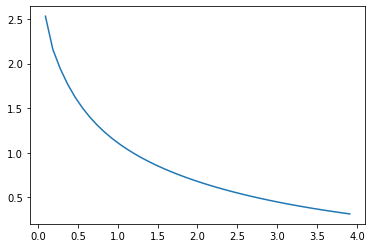

In [12]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

## GAUSSIAN PROCESS EMULATOR

## The Gaussian process emulator uses the following default parameters:

- paramList=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
- kmax_Mpc=10
- ndeg=4

### Example 1: Train custom emulator 

#### with a defined training_set

In [13]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21')

#### with a custom archive

In [14]:
emulator = GPEmulator(archive=archive)

Use custom archive provided by the user
Selected custom emulator
Training GP on 330 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.33 seconds


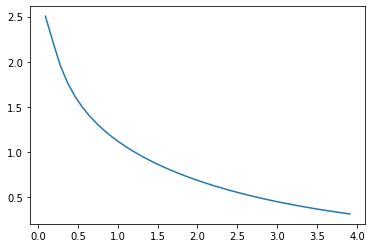

In [17]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

#### if both are provided, the emulator fails

### Example 2: Pre-defined GP emulators:

In [15]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen21')

In [16]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen23')

In [18]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21')

## LaCE-Nyx emulator (NN)

In [19]:
# emulators will use different emulator parameters depending on the archive
#gadget_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
nyx_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'lambda_P']

In [ ]:
# you could specify here the path to the Nyx files, or set a NYX_PATH variable
#nyx_fname = '/data/desi/scratch/HydroData/Emulator/nyx_files/models.hdf5'
nyx_fname=None
archive = nyx_archive.NyxArchive(file_name=nyx_fname)

In [ ]:
emulator = NNEmulator(archive=archive, nepochs=1,emu_params=nyx_emu_params)

In [ ]:
training_data = archive.get_training_data()
kMpc = training_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

In [ ]:
# test emulator by making simple plot
testing_data = archive.get_testing_data(sim_label='nyx_0')
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

In [ ]:
if thorough:
    emulator = NNEmulator(training_set='Nyx23',emu_param=nyx_emu_params,nepochs=1)
    emulator = NNEmulator(archive=archive, emulator_label='Cabayol23_Nyx', nepochs=1)

In [ ]:
if thorough:
    emulator = NNEmulator(training_set='Nyx23',emu_param=nyx_emu_params,nepochs=1)
    emulator = NNEmulator(archive=archive, emulator_label='Cabayol23_Nyx', nepochs=1)

# Older stuff by Laura

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import sys
import sklearn

import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

# LaCE modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d
from lace.emulator import utils
from lace.emulator import nn_architecture
from lace.emulator import base_emulator

cosmo_fid = camb_cosmo.get_cosmology()
import copy


class NNEmulator(base_emulator.BaseEmulator):
    """A class for training an emulator.

    Args:
        archive (class): Data archive used for training the emulator.
            Required when using a custom emulator.
        training_set: Specific training set.  Options are
            'Cabayol23'.
        emu_params (lsit): A list of emulator parameters.
        emulator_label (str): Specific emulator label. Options are
            'Cabayol23' and 'Cabayol23_Nyx'.
        kmax_Mpc (float): The maximum k in Mpc^-1 to use for training. Default is 3.5.
        nepochs (int): The number of epochs to train for. Default is 200.
        model_path (str): The path to a pretrained model. Default is None.
        train (bool): Wheather to train the emulator or not. Default True. If False, a model path must is required.
        initial_weights (bool): Wheather to initialize the network always with a set of pre-defined random weights
    """

    def __init__(
        self,
        archive=None,
        training_set=None,
        emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc'], 
        emulator_label=None,
        kmax_Mpc=4,
        ndeg=5,
        nepochs=100,
        step_size=75,
        train=True,
        initial_weights=True,
        save_path=None,
        model_path=None,
    ):
        self.emu_params = emu_params
        self.kmax_Mpc = kmax_Mpc
        self.nepochs = nepochs
        self.step_size = step_size
        self.model_path = model_path
        
        self.ndeg = ndeg
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.save_path = save_path
        self.lace_path = os.environ["LACE_REPO"] + "/"
        self.models_dir = os.path.join(self.lace_path, "lace/emulator/")
        
        #temporary hack:

        # check input #
        training_set_all = ["Pedersen21", "Cabayol23", "Nyx23"]
        if (archive!=None)&(training_set!=None):
            raise ValueError("Conflict! Both custom archive and training_set provided")
        
        if training_set is not None:
            try:
                if training_set in training_set_all:
                    print(f"Selected training set from {training_set}")
                    pass
                else:
                    print(
                        "Invalid training_set value. Available options: ",
                        training_set_all,
                    )
                    raise
            except:
                print("An error occurred while checking the training_set value.")
                raise
                
            # read Gadget archive with the right postprocessing
            
            #self.archive=gadget_archive.GadgetArchive(postproc=training_set)
            #self.training_data = self.archive.get_training_data()
            
                    
        elif archive!=None and training_set==None:
            print("Use custom archive provided by the user")
            self.archive = archive
            self.training_data = archive.get_training_data()

        elif (archive==None)&(training_set==None):
            raise(ValueError('Archive or training_set must be provided'))
            
        if training_set in ['Pedersen21','Cabayol23']:
            self.archive=gadget_archive.GadgetArchive(postproc=training_set)
            self.training_data = self.archive.get_training_data()
            
        elif training_set in ['Nyx23']:
            self.archive = nyx_archive.NyxArchive(file_name=nyx_fname)
            self.training_data = archive.get_training_data()
            
            
        emulator_label_all = ["Cabayol23", "Cabayol23_Nyx"]
        if emulator_label is not None:  
            try:
                if emulator_label in emulator_label_all:
                    print(f"Select emulator in {emulator_label}")
                    pass
                else:
                    print(
                        "Invalid emulator_label value. Available options: ",
                        emulator_label_all,
                    )
                    raise

            except:
                print("An error occurred while checking the emulator_label value.")
                raise

            if emulator_label == "Cabayol23":
                
                print(
                    r"Neural network emulating the optimal P1D of Gadget simulations "
                    + "fitting coefficients to a 5th degree polynomial. It "
                    + "goes to scales of 4Mpc^{-1} and z<4.5. The parameters "
                    + "passed to the emulator will be overwritten to match "
                    + "these ones"
                )
                self.emu_params = ["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"]
                self.kmax_Mpc, self.ndeg, self.nepochs,self.step_size = 4, 5, 100, 75
                
            if emulator_label == "Cabayol23_Nyx":
                
                print(
                    r"Neural network emulating the optimal P1D of Nyx simulations "
                    + "fitting coefficients to a 5th degree polynomial. It "
                    + "goes to scales of 4Mpc^{-1} and z<4.5. The parameters "
                    + "passed to the emulator will be overwritten to match "
                    + "these ones"
                )
                

                self.emu_params = ["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "lambda_P"]
                self.kmax_Mpc, self.ndeg, self.nepochs, self.step_size = 4, 5, 1000, 750
                                
                
        else:
            print("Selected custom emulator")            
            
        if train == False: 
            if (emulator_label==None)|(training_set==None):
                raise ValueError("Pre-trained models can only be loaded passing an emulator_label and a training_set")

            if self.model_path == None:
                raise ValueError("If train==False, model path is required.")

            else:
                pretrained_weights = torch.load(
                    os.path.join(self.models_dir, self.model_path), map_location="cpu"
                )
                self.nn = nn_architecture.MDNemulator_polyfit(
                    nhidden=5, ndeg=self.ndeg
                )
                self.nn.load_state_dict(pretrained_weights['model'])
                self.nn.to(self.device)
                print("Model loaded. No training needed")
                
                emulator_settings = pretrained_weights['emulator_params']
                
                training_set_loaded = emulator_settings['training_set']
                emulator_label_loaded = emulator_settings['emulator_label']        
                drop_sim_loaded = emulator_settings['drop_sim']   
                
                if (emulator_label_loaded!=emulator_label)|(training_set_loaded!=training_set):
                    raise ValueError(f"This model correspond to an emulator_label {emulator_label} and "+
                                     f"a training set {training_set_loaded} and does not match the passed arguments"
                                    )
                    
                if emulator_settings['drop_sim'] != None:
                    dropsim=emulator_params['drop_sim']
                    print(f'WARNING: Model trained without simulation set {dropsim}') 
                    
                
            if training_set=='Cabayol23':
                
                kMpc_train = self._obtain_sim_params()
                log_kMpc_train = torch.log10(kMpc_train).to(self.device)
                self.log_kMpc = log_kMpc_train
                
            elif training_set=='Nyx':
                raise ValueError("Work in progress")
                
        else:           
                                        
            self.initial_weights = initial_weights
            if self.initial_weights == True:
                # loads set of pre-defined random weights
                if self.kmax_Mpc == 4:
                    self.initial_weights_path = os.path.join(
                        self.models_dir, "initial_params/initial_weights.pt"
                    )
                if self.kmax_Mpc == 8:
                    self.initial_weights_path = os.path.join(
                        self.models_dir, "initial_params/initial_weights_extended.pt"
                    )


            self.train()

            if self.save_path != None:
                # saves the model in the predefined path after training
                self.save_emulator()

    def _sort_dict(self, dct, keys):
        """
        Sort a list of dictionaries based on specified keys.

        Args:
            dct (list): List of dictionaries to be sorted.
            keys (list): List of keys to sort the dictionaries by.

        Returns:
            list: The sorted list of dictionaries.
        """
        for d in dct:
            sorted_d = {
                k: d[k] for k in keys
            }  # create a new dictionary with only the specified keys
            d.clear()  # remove all items from the original dictionary
            d.update(
                sorted_d
            )  # update the original dictionary with the sorted dictionary
        return dct

    def _obtain_sim_params(self):
        """
        Obtain simulation parameters.

        Returns:
            k_Mpc (np.ndarray): Simulation k values.
            Nz (int): Number of redshift values.
            Nk (int): Number of k values.
            k_Mpc_train (tensor): k values in the k training range
        """

        # AFR: not sure exactly what we are doing here. 
        # It looks like some code to set self.k_Mpc and self.Nz
        sim_0 = copy.deepcopy(self.archive)
        sim_0_training_data = sim_0.get_training_data()
        sim_0_training_data = [d for d in sim_0_training_data if d["sim_label"] == "mpg_0"]
        sim_zs = [data["z"] for data in sim_0_training_data]
        Nz = len(sim_zs)
        k_Mpc = sim_0.data[0]["k_Mpc"]
        self.k_Mpc = k_Mpc

        k_mask = (k_Mpc < self.kmax_Mpc) & (k_Mpc > 0)
        k_Mpc_train = k_Mpc[k_mask]
        Nk = len(k_Mpc_train)
        k_Mpc_train = torch.Tensor(k_Mpc_train)

        self.Nz = Nz
        self.Nk = Nk
        

        data = [
            {
                key: value
                for key, value in self.training_data[i].items()
                if key in self.emu_params
            }
            for i in range(len(self.training_data))
        ]
        data = self._sort_dict(
            data, self.emu_params
        )  # sort the data by emulator parameters
        data = [list(data[i].values()) for i in range(len(self.training_data))]
        data = np.array(data)

        paramlims = np.concatenate(
            (
                data.min(0).reshape(len(data.min(0)), 1),
                data.max(0).reshape(len(data.max(0)), 1),
            ),
            1,
        )
        self.paramLims = paramlims

        training_label = [
            {
                key: value
                for key, value in self.training_data[i].items()
                if key in ["p1d_Mpc"]
            }
            for i in range(len(self.training_data))
        ]
        training_label = [
            list(training_label[i].values())[0][1 : (self.Nk + 1)].tolist()
            for i in range(len(self.training_data))
        ]
        training_label = np.array(training_label)
        self.yscalings = np.median(training_label)

        return k_Mpc_train

    def _get_training_data_nn(self):
        """
        Given an archive and key_av, it obtains the training data based on self.emu_params
        Sorts the training data according to self.emu_params and scales the data based on self.paramLims
        Finally, it returns the training data as a torch.Tensor object.
        """
        training_data = [
            {
                key: value
                for key, value in self.training_data[i].items()
                if key in self.emu_params
            }
            for i in range(len(self.training_data))
        ]
        training_data = self._sort_dict(training_data, self.emu_params)
        training_data = [
            list(training_data[i].values())
            for i in range(len(self.training_data))
        ]

        training_data = np.array(training_data)
        training_data = (training_data - self.paramLims[:, 0]) / (
            self.paramLims[:, 1] - self.paramLims[:, 0]
        ) - 0.5
        training_data = torch.Tensor(training_data)

        return training_data

    def _get_training_pd1_nn(self):
        """
        Method to get the p1d_Mpc values from the training data in a format that the NN emulator can ingest
        It gets the P!D from the archive and scales it.
        Finally, it returns the scaled values as a torch.Tensor object along with the scaling factor.
        """
        training_label = [
            {
                key: value
                for key, value in self.training_data[i].items()
                if key in ["p1d_Mpc"]
            }
            for i in range(len(self.training_data))
        ]
        training_label = [
            list(training_label[i].values())[0][1 : (self.Nk + 1)].tolist()
            for i in range(len(self.training_data))
        ]

        training_label = np.array(training_label)
        # yscalings = np.median(training_label)
        training_label = np.log10(training_label / self.yscalings)
        training_label = torch.Tensor(training_label)

        # self.yscalings=yscalings

        return training_label  # , yscalings


    def train(self):
        """
        Trains the emulator with given key_list using the archive data.
        Args:
        key_list (list): List of keys to be used for training

        Returns:None
        """

        kMpc_train = self._obtain_sim_params()

        log_kMpc_train = torch.log10(kMpc_train).to(self.device)

        self.log_kMpc = log_kMpc_train

        self.nn = nn_architecture.MDNemulator_polyfit(nhidden=5, ndeg=self.ndeg)
        if self.initial_weights == True:
            initial_weights_params = torch.load(self.initial_weights_path, map_location="cpu")
            self.nn.load_state_dict(initial_weights_params)

        optimizer = optim.Adam(
            self.nn.parameters(), lr=1e-3, weight_decay=1e-4
        )  #
        scheduler = lr_scheduler.StepLR(optimizer, self.step_size, gamma=0.1)

        training_data = self._get_training_data_nn()
        training_label = self._get_training_pd1_nn()


        trainig_dataset = TensorDataset(training_data, training_label)
        loader_train = DataLoader(trainig_dataset, batch_size=100, shuffle=True)

        self.nn.to(self.device)

        t0 = time.time()
        for epoch in range(self.nepochs):
            for datain, p1D_true in loader_train:
                optimizer.zero_grad()

                coeffsPred, coeffs_logerr = self.nn(datain.to(self.device))  #
                coeffs_logerr = torch.clamp(coeffs_logerr, -10, 5)
                coeffserr = torch.exp(coeffs_logerr) ** 2

                powers = torch.arange(0, self.ndeg + 1, 1).to(self.device)
                P1Dpred = torch.sum(
                    coeffsPred[:, powers, None]
                    * (self.log_kMpc[None, :] ** powers[None, :, None]),
                    axis=1,
                )

                powers_err = torch.arange(0, self.ndeg * 2 + 1, 2).to(self.device)
                P1Derr = torch.sqrt(
                    torch.sum(
                        coeffserr[:, powers, None]
                        * (self.log_kMpc[None, :] ** powers_err[None, :, None]),
                        axis=1,
                    )
                )

                P1Dlogerr = torch.log(P1Derr)

                log_prob = ((P1Dpred - p1D_true.to(self.device)) / P1Derr).pow(
                    2
                ) + 2 * P1Dlogerr  #

                loss = torch.nansum(log_prob, 1)
                loss = torch.nanmean(loss, 0)

                loss.backward()
                optimizer.step()

            scheduler.step()

    def save_emulator(self):
        torch.save(self.nn.state_dict(), self.save_path)

        
    def emulate_p1d_Mpc(self, model, k_Mpc, return_covar=False, z=None):
        k_Mpc = torch.Tensor(k_Mpc)
        log_kMpc = torch.log10(k_Mpc).to(self.device)

        with torch.no_grad():

            emu_call = {}
            for param in self.emu_params:
                emu_call[param] = model[param]

            emu_call = {k: emu_call[k] for k in self.emu_params}
            emu_call = list(emu_call.values())
            emu_call = np.array(emu_call)

            emu_call = (emu_call - self.paramLims[:, 0]) / (
                self.paramLims[:, 1] - self.paramLims[:, 0]
            ) - 0.5
            emu_call = torch.Tensor(emu_call).unsqueeze(0)

            # ask emulator to emulate P1D (and its uncertainty)
            coeffsPred, coeffs_logerr = self.nn(emu_call.to(self.device))
            coeffs_logerr = torch.clamp(coeffs_logerr, -10, 5)
            coeffserr = torch.exp(coeffs_logerr) ** 2

            powers = torch.arange(0, self.ndeg + 1, 1).to(self.device)
            emu_p1d = torch.sum(
                coeffsPred[:, powers, None]
                * (log_kMpc[None, :] ** powers[None, :, None]),
                axis=1,
            )

            powers_err = torch.arange(0, self.ndeg * 2 + 1, 2).to(self.device)
            emu_p1derr = torch.sqrt(
                torch.sum(
                    coeffserr[:, powers, None]
                    * (log_kMpc[None, :] ** powers_err[None, :, None]),
                    axis=1,
                )
            )

            emu_p1d = emu_p1d.detach().cpu().numpy().flatten()
            emu_p1derr = emu_p1derr.detach().cpu().numpy().flatten()

            emu_p1derr = 10 ** (emu_p1d) * np.log(10) * emu_p1derr * self.yscalings
            emu_p1d = 10 ** (emu_p1d) * self.yscalings

        if return_covar==True:
            covar = np.outer(emu_p1derr, emu_p1derr)
            return emu_p1d, covar
        
        else:
            return emu_p1d


In [ ]:
training_data = archive.get_training_data()

In [ ]:
data = [
    {
        key: value
        for key, value in training_data[i].items()
        if key in nyx_emu_params
    }
    for i in range(len(training_data))
]

In [ ]:
data = [list(data[i].values()) for i in range(len(training_data))]
data = np.array(data)

In [ ]:
np.isnan(data).any()

In [ ]:
paramlims = np.concatenate(
    (
        data.min(0).reshape(len(data.min(0)), 1),
        data.max(0).reshape(len(data.max(0)), 1),
    ),
    1,
)
paramlims

In [ ]:
kMpc = training_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

In [ ]:
emulator = NNEmulator(archive=archive, nepochs=1,
                      emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc','gamma','lambda_P' ])

In [ ]:
emulator = NNEmulator(archive=archive, emulator_label='Cabayol23_Nyx', nepochs=1)

In [ ]:
p1d = emulator.emulate_p1d_Mpc(training_data[0],kMpc)

In [ ]:
emulator.paramLims

In [ ]:
    def _obtain_sim_params(self):
        """
        Obtain simulation parameters.

        Returns:
            k_Mpc (np.ndarray): Simulation k values.
            Nz (int): Number of redshift values.
            Nk (int): Number of k values.
            k_Mpc_train (tensor): k values in the k training range
        """

        # AFR: not sure exactly what we are doing here. 
        # It looks like some code to set self.k_Mpc and self.Nz
        sim_0 = copy.deepcopy(self.archive)
        sim_0_training_data = sim_0.get_training_data()
        sim_0_training_data = [d for d in sim_0_training_data if d["sim_label"] == "mpg_0"]
        sim_zs = [data["z"] for data in sim_0_training_data]
        Nz = len(sim_zs)
        k_Mpc = sim_0.data[0]["k_Mpc"]
        self.k_Mpc = k_Mpc

        k_mask = (k_Mpc < self.kmax_Mpc) & (k_Mpc > 0)
        k_Mpc_train = k_Mpc[k_mask]
        Nk = len(k_Mpc_train)
        k_Mpc_train = torch.Tensor(k_Mpc_train)

        self.Nz = Nz
        self.Nk = Nk

        data = [
            {
                key: value
                for key, value in self.training_data[i].items()
                if key in self.emu_params
            }
            for i in range(len(self.training_data))
        ]
        data = self._sort_dict(
            data, self.emu_params
        )  # sort the data by emulator parameters
        data = [list(data[i].values()) for i in range(len(self.training_data))]
        data = np.array(data)

        paramlims = np.concatenate(
            (
                data.min(0).reshape(len(data.min(0)), 1),
                data.max(0).reshape(len(data.max(0)), 1),
            ),
            1,
        )
        self.paramLims = paramlims

        training_label = [
            {
                key: value
                for key, value in self.training_data[i].items()
                if key in ["p1d_Mpc"]
            }
            for i in range(len(self.training_data))
        ]
        training_label = [
            list(training_label[i].values())[0][1 : (self.Nk + 1)].tolist()
            for i in range(len(self.training_data))
        ]
        training_label = np.array(training_label)
        self.yscalings = np.median(training_label)

        return k_Mpc_train